In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import random

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras_squeezenet import SqueezeNet

from textwrap import wrap
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
%matplotlib inline
DIRECTORY_2 = '/home/joe/Dev/robot/Human Pilot Batch 2'
CSV_FILE_2 = '/home/joe/Dev/robot/human_pilot_batch_2_labels.csv'
filenames = os.listdir(DIRECTORY_2)
df2 = pd.read_csv(CSV_FILE_2)
DIRECTORY_3 = '/home/joe/Dev/robot/human_piloted_3'
CSV_FILE_3 = '/home/joe/Dev/robot/human_piloted_3_labels.csv'
filenames = os.listdir(DIRECTORY_3)
df3 = pd.read_csv(CSV_FILE_3)
#DIRECTORY_4 = '/home/joe/Dev/robot/human_piloted_4'
#CSV_FILE_4 = '/home/joe/Dev/robot/human_piloted_4_labels.csv'
#filenames = os.listdir(DIRECTORY_4)
#df4 = pd.read_csv(CSV_FILE_4)
DIRECTORY_5 = '/home/joe/Dev/robot/human_piloted_5'
CSV_FILE_5 = '/home/joe/Dev/robot/human_piloted_5_labels.csv'
filenames = os.listdir(DIRECTORY_5)
df5 = pd.read_csv(CSV_FILE_5)
DIRECTORY_1 = '/home/joe/Dev/robot/auto pilot batch 1'
CSV_FILE_1 = '/home/joe/Dev/robot/auto_pilot_1_labels.csv'
filenames = os.listdir(DIRECTORY_1)
df1 = pd.read_csv(CSV_FILE_1)

width_height = 224
BATCH_SIZE = 200
#BATCH_SIZE = 10809
np.random.seed(42)

In [17]:
def load_image(filename1, filename2, filename3, filename4):
    img1 = cv2.imread('{}'.format(filename1))
    img2 = cv2.imread('{}'.format(filename2))
    img3 = cv2.imread('{}'.format(filename3))
    img4 = cv2.imread('{}'.format(filename4))
    img1 = cv2.resize(img1, (112, 112))
    img2 = cv2.resize(img2, (112, 112))
    img3 = cv2.resize(img3, (112, 112))
    img4 = cv2.resize(img4, (112, 112))

    output = np.zeros((225, 225, 3))
    output[0:112,0:112] = img1
    output[113:225,0:112] = img2
    output[0:112,113:225] = img3
    output[113:225,113:225] = img4
    return output[0:224,0:224]

def mean_normalize(img):
    return (img - img.mean()) / (img.max() - img.min())

def normalize(img):
    return img / 255

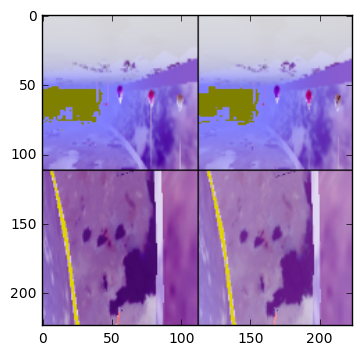

In [18]:
#hmnfwdL48.png hmndwnL48.png hmnfwdL49.png hmndwnL49.png
filename1 = DIRECTORY_2 + '/' + 'hmnfwdL48.png'
filename2 = DIRECTORY_2 + '/' + 'hmndwnL48.png'
filename3 = DIRECTORY_2 + '/' + 'hmnfwdL49.png'
filename4 = DIRECTORY_2 + '/' + 'hmndwnL49.png'
img = load_image(filename1, filename2, filename3, filename4)
plt.imshow(img)

In [19]:
def get_x_data(images_df, positions_df, num_rows, directory):
    #images4 = pd.DataFrame(columns=['filename1','filename2','filename3','filename4'])
    x_data = []
    #x = positions_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(positions_df)*.6
    scaled = scaled + .2
    #x_pos_df = pd.DataFrame(scaled)
    for i in range(0, num_rows-1):
        dict_images = {'filename1': directory + '/' + images_df[i][0], 'filename2': directory + '/' + images_df[i][1],
                       'filename3': directory + '/' + images_df[i+1][0], 'filename4': directory + '/' + images_df[i+1][1],
                       'position.x': scaled[i][0],
                       'position.y': scaled[i][1],
                       'position.z': scaled[i][2],
                       'rotation.y': scaled[i][3]}
        x_data.append(dict_images)
    df_x_data = pd.DataFrame(x_data, columns=['filename1', 'filename2', 'filename3', 'filename4',
                                                    'position.x', 'position.y', 'position.z', 'rotation.y'])
    return df_x_data


In [20]:
def get_x_data_frame(data_frame, directory):
    num_rows = len(data_frame.index)
    images_df = data_frame[['filename1','filename2']].values
    positions_df = data_frame[['position.x','position.y','position.z','rotation.y']].values
    return get_x_data(images_df, positions_df, num_rows, directory)
#test_dataframe_values = (get_x_data_frame(df4, DIRECTORY_4))
#print(test_dataframe_values.iat[0,0])


In [21]:
def get_y_data(positions_df, num_rows):
    y_data = []
    for i in range(0, num_rows-1):
        dict_images = {'position.x': positions_df[i+1][0], 'position.y': positions_df[i+1][1],
                       'position.z': positions_df[i+1][2], 'rotation.y': positions_df[i+1][3],
                       'pos_delta.x': positions_df[i+1][0] - positions_df[i][0],
                       'pos_delta.y': positions_df[i+1][1] - positions_df[i][1],
                       'pos_delta.z': positions_df[i+1][2] - positions_df[i][2],
                       'rot_delta.y': positions_df[i+1][3] - positions_df[i][3]}
        y_data.append(dict_images)
    df_y_data = pd.DataFrame(y_data, columns=['position.x', 'position.y', 'position.z', 'rotation.y',
                                                    'pos_delta.x', 'pos_delta.y', 'pos_delta.z', 'rot_delta.y'])
    return df_y_data

In [22]:
def get_y_data_frame(data_frame):
    num_rows = len(data_frame.index)
    images_df = data_frame[['filename1','filename2']].values
    positions_df = data_frame[['position.x','position.y','position.z','rotation.y']].values
    return get_y_data( positions_df, num_rows)
get_y_data_frame(df5)

,position.x,position.y,position.z,rotation.y,pos_delta.x,pos_delta.y,pos_delta.z,rot_delta.y
0,-0.186969,-1.422559,-27.637725,1.229602,-0.150598,-0.000724,0.055423,5.229611e-04
1,-0.222487,-1.420104,-27.623818,1.229703,-0.035518,0.002455,0.013907,1.011923e-04
2,-0.270371,-1.417883,-27.605497,1.229836,-0.047883,0.002222,0.018321,1.327696e-04
3,-0.311331,-1.415438,-27.589696,1.229946,-0.040960,0.002445,0.015800,1.103524e-04
4,-0.359194,-1.413214,-27.571527,1.230071,-0.047863,0.002223,0.018169,1.251908e-04
5,-0.394600,-1.410677,-27.557868,1.230162,-0.035406,0.002537,0.013659,9.044310e-05
6,-0.439183,-1.408558,-27.541090,1.230272,-0.044584,0.002119,0.016778,1.100969e-04
7,-0.490109,-1.380004,-27.522254,1.213921,-0.050926,0.028555,0.018836,-1.635099e-02
8,-0.487570,-1.297676,-27.522531,1.093321,0.002539,0.082328,-0.000278,-1.205995e-01
9,-0.485704,-1.236324,-27.522913,1.026088,0.001866,0.061352,-0.000382,-6.723326e-02


In [23]:
def get_class_weights():
    data = get_y_data_frame(df5)
    max_val = data.max(axis=0)
    min_val = data.min(axis=0)
    delta = max_val - min_val
    class_weights = (1.0 / delta.values)/ 8
    return class_weights
get_class_weights()

array([ 0.00330231,  0.02630945,  0.00242466,  0.04023579,  0.16485794,
        0.25969961,  0.03305049,  0.04529953])

In [24]:
#X = get_x_data(images_df, positions_df, num_rows).values
X = get_x_data_frame(df1, DIRECTORY_1)
X = X.append(get_x_data_frame(df2, DIRECTORY_2), ignore_index=True)
X = X.append(get_x_data_frame(df3, DIRECTORY_3), ignore_index=True)
#X = X.append(get_x_data_frame(df4, DIRECTORY_4), ignore_index=True)
X = X.append(get_x_data_frame(df5, DIRECTORY_5), ignore_index=True)
y = get_y_data_frame(df1)
y = y.append(get_y_data_frame(df2), ignore_index=True)
y = y.append(get_y_data_frame(df3), ignore_index=True)
#y = y.append(get_y_data_frame(df4), ignore_index=True)
y = y.append(get_y_data_frame(df5), ignore_index=True)
#y = get_y_data(positions_df, num_rows).values
X

,filename1,filename2,filename3,filename4,position.x,position.y,position.z,rotation.y
0,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.800000,0.800000,0.200121,0.555553
1,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.799989,0.793303,0.200091,0.555753
2,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.799981,0.788925,0.200050,0.555883
3,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.799974,0.779390,0.200000,0.556102
4,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.798312,0.774547,0.201500,0.556216
5,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.796944,0.738379,0.202728,0.514594
6,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.796921,0.696870,0.202698,0.479378
7,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.796923,0.694643,0.202646,0.484427
8,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.796925,0.692050,0.202598,0.489627
9,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,/home/joe/Dev/robot/auto pilot batch 1/autofwd...,/home/joe/Dev/robot/auto pilot batch 1/autodwn...,0.796928,0.689361,0.202554,0.494579


In [25]:
n_features = 1
n_classes = y.shape[1]

X, y = shuffle(X.values, y.values)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
print(X_train)
print('We\'ve got {} feature rows and {} labels'.format(len(X_train), len(y_train)))
print('Each row has {} features'.format(n_features))
print('and we have {} classes'.format(n_classes))
assert(len(y_train) == len(X_train))
print('We use {} rows for training and {} rows for validation'.format(len(X_train), len(X_valid)))
print('So far, so good')

[['/home/joe/Dev/robot/Human Pilot Batch 2/hmnfwdU76.png'
  '/home/joe/Dev/robot/Human Pilot Batch 2/hmndwnU76.png'
  '/home/joe/Dev/robot/Human Pilot Batch 2/hmnfwdU77.png' ...,
  0.6252656468774527 0.321210687533649 0.6063230198556475]
 ['/home/joe/Dev/robot/Human Pilot Batch 2/hmnfwdU1154.png'
  '/home/joe/Dev/robot/Human Pilot Batch 2/hmndwnU1154.png'
  '/home/joe/Dev/robot/Human Pilot Batch 2/hmnfwdU1155.png' ...,
  0.5732857046499003 0.759007805875547 0.31007759116776384]
 ['/home/joe/Dev/robot/human_piloted_5/autofwdB6170.png'
  '/home/joe/Dev/robot/human_piloted_5/autodwnB6170.png'
  '/home/joe/Dev/robot/human_piloted_5/autofwdB6171.png' ...,
  0.568885811521188 0.2917671975441168 0.4694382200605306]
 ..., 
 ['/home/joe/Dev/robot/human_piloted_5/autofwdB7006.png'
  '/home/joe/Dev/robot/human_piloted_5/autodwnB7006.png'
  '/home/joe/Dev/robot/human_piloted_5/autofwdB7007.png' ...,
  0.5111466069605037 0.5823362839535136 0.5170515967361453]
 ['/home/joe/Dev/robot/human_piloted_5/

First, I am going to 

In [11]:

images = Input(shape=(224,224,3),name = 'image_input')
positions = Input(shape=(4,),name = 'position_input')
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)
for layer in inception_v3_model.layers:
    layer.trainable=False
inception_v3_model.summary()

#Use the generated model 
inception_v3_model_conv = inception_v3_model(images)
#forward = GlobalAveragePooling2D()(inception_v3_model_conv)
cnn = GlobalAveragePooling2D()(inception_v3_model_conv)
final = concatenate([cnn, positions])    #forward
final = Dense(1024,activation="relu")(final)
final = Dropout(0.5)(final)
final = Dense(1024,activation="relu")(final)
final = Dropout(0.5)(final)
final = Dense(8, activation='linear')(final)

#Create model 
model = Model(input=[images, positions], output=final)

#In the summary, weights and layers from InceptionV3 part will be hidden, but they will be fit during the training
model.summary()
#model.add(Dense(2,1,init=’uniform’, activation=’linear’))
#model.compile(loss='mse', optimizer='rmsprop')
adam = Adam(lr=0.001, clipvalue=1.5)
model.compile(loss='mse', optimizer=adam)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

/home/joe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [26]:
def generator(X, y, batch_size=BATCH_SIZE):
    X_copy, y_copy = X, y
    while True:
        for i in range(0, len(X_copy), batch_size):
            X_image, X_positions, y_result = [], [], []
            if i<len(X_copy):
                for x, y in zip(X_copy[i:i+batch_size], y_copy[i:i+batch_size]):
                    #print('x[0], x[1], x[2], x[3]', x[0], x[1], x[2], x[3])
                    try:
                        rx1, rx2, ry = [normalize(load_image(x[0], x[1], x[2], x[3]))], [x[4] + random.gauss(0, .08)
                                                                                         ,x[5] + random.gauss(0, .08)
                                                                                         ,x[6] + random.gauss(0, .08)
                                                                                         ,x[7] + random.gauss(0, .08)
                                                                                            ], [y]
                        #print(x[0], x[1], x[2], x[3])
                        y = np.array(ry)
                        X_image.append(rx1)
                        X_positions.append([rx2])
                        y_result.append(y)
                    except:
                        pass
                X_result_1, X_result_2, y_result = np.concatenate(X_image), np.concatenate(X_positions), np.concatenate(y_result)
                yield [X_result_1, X_result_2], y_result
                #print(y_result)
                #yield X_result_1, y_result
        #X_copy, y_copy = shuffle(X_copy, y_copy)

In [13]:
gen = generator(X_train, y_train)

In [ ]:
test_x, test_y = next(gen)

In [27]:
EPOCHS = 40
PER_EPOCH = 9

class_w = get_class_weights()
filepath="/home/joe/Dev/robot/models/InceptionV3_fc512_X2_pos-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit_generator(
    generator(X_train, y_train),
    steps_per_epoch=PER_EPOCH,
    epochs=EPOCHS,
    validation_data=generator(X_valid, y_valid),
    #validation_steps=len(y_valid)//(BATCH_SIZE),
    class_weight = class_w,
    validation_steps=4,
    callbacks=callbacks_list
)

Epoch 1/40
9/9 [==============================] - 1899s - loss: 18.0681 - val_loss: 12.0022
Epoch 2/40
9/9 [==============================] - 1872s - loss: 18.7982 - val_loss: 13.3956
Epoch 3/40
9/9 [==============================] - 1873s - loss: 16.9385 - val_loss: 12.0943
Epoch 4/40
9/9 [==============================] - 1822s - loss: 16.1318 - val_loss: 11.3070
Epoch 5/40
9/9 [==============================] - 1587s - loss: 15.7172 - val_loss: 12.3813
Epoch 6/40
9/9 [==============================] - 1465s - loss: 16.2165 - val_loss: 14.1450
Epoch 7/40
9/9 [==============================] - 1419s - loss: 16.3966 - val_loss: 10.1554
Epoch 8/40
9/9 [==============================] - 1306s - loss: 15.8082 - val_loss: 10.8912
Epoch 9/40
9/9 [==============================] - 1330s - loss: 14.5775 - val_loss: 10.6153
Epoch 10/40
9/9 [==============================] - 1339s - loss: 15.1079 - val_loss: 9.1728
Epoch 11/40
9/9 [==============================] - 1258s - loss: 14.4087 - val_l

In [ ]:
list_X_valid = list(X_train)
list_y_valid = list(y_train)
for i in range(0, len(list_X_valid)):
    list_fil = list(list_X_valid[i])
    print('')
    print('')
    print(i)
    print('actual pos: ', list_y_valid[i])
#    print('image1: ', list_fil[0])
#    print('image2: ', list_fil[1])
#    print('image3: ', list_fil[2])
#    print('image4: ', list_fil[3])
    img = normalize(load_image(list_fil[0], list_fil[1], list_fil[2], list_fil[3]))
    '''
   # display(
  #  sample_images,
 #   cols=1#,
    #titles=[t for t in samples['filename1']]
#)
'''
#    pre_img = preprocess(img)
    pre_img = img.reshape((1, width_height, width_height, 3))
#    print(pre_img.shape)
    positions = np.asarray([list_fil[4], list_fil[5], list_fil[6], list_fil[7]])
    #positions = np.asarray([.5, .5, .5, .5])
    positions = positions.reshape(1,4)
    predicted = model.predict([pre_img,positions])
    print('')
    print('predicted: ', predicted)
    print('')



0
actual pos:  [ -2.59273909e+01  -2.12137187e+00  -1.86920516e+01   5.52302157e-01
  -2.82204620e-02  -4.49957890e-03   4.57968251e-02   1.86717800e-04]

predicted:  [[ -2.21118469e+01  -1.81255853e+00  -1.87389469e+01   7.33141005e-01
   -1.15410261e-01  -1.75805926e-01  -6.22094609e-02   1.03884889e-02]]



1
actual pos:  [ -2.32749752e+01  -2.43475754e+00   1.47382169e+01  -9.74945051e-01
   4.34192617e-02   5.49215480e-03   2.95181542e-02  -1.65364080e-03]

predicted:  [[-24.5773716   -3.48675418  14.1034584   -0.1652707   -0.18557623
   -0.10311689   0.22898249   0.02724018]]



2
actual pos:  [ -1.57258949e+01  -2.73213732e+00  -1.98014484e+01   1.27794991e-01
   3.56025100e-04  -2.65096974e-02  -1.66493180e-03   2.82942101e-01]

predicted:  [[ -1.61194363e+01  -2.06300259e+00  -1.81338043e+01   6.19076490e-01
   -6.86111376e-02  -6.03244156e-02  -1.26934946e-01  -6.69521745e-03]]



3
actual pos:  [ -2.33433582e+01  -4.91402347e+00  -1.68522251e+01   6.14876841e-01
  -4.13745